In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import mne
from mne import io
from mne import read_epochs
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
class CNN(nn.Module):
    def __init__(self, input_x, input_dim, hidden_dims, output_dim, dropout):
        super(CNN, self).__init__()
        self.seq_len = input_x[-1]
        self.hidden_dims = hidden_dims
        
        # layer 1 (BatchNorm)
        self.layer1 = nn.BatchNorm2d(input_dim)     
        
        # layer 2 (Conv2d, tanh)
        self.layer2 = nn.Sequential(nn.Conv2d(input_dim, self.hidden_dims[1], kernel_size = (32, self.hidden_dims[0]), 
                                        stride = 1), nn.Tanh())     
        
        # layer 3 (Conv2d + Conv2d + Conv2d, BatchNorm, tanh, dropout)
        self.layer3_1 = nn.Sequential(nn.Conv2d(self.hidden_dims[1], self.hidden_dims[2],kernel_size = (1, 5), 
                                        stride = (1, 5)), nn.BatchNorm2d(self.hidden_dims[2]), nn.Tanh(), nn.Dropout2d(dropout))
        self.layer3_2 = nn.Sequential(nn.Conv2d(self.hidden_dims[1], self.hidden_dims[2], kernel_size = (1, 10), 
                                        stride = (1, 10)), nn.BatchNorm2d(self.hidden_dims[2]), nn.Tanh(), nn.Dropout2d(dropout))
        self.layer3_3 = nn.Sequential(nn.Conv2d(self.hidden_dims[1], self.hidden_dims[2], kernel_size = (1, 15), 
                                        stride = (1, 15)), nn.BatchNorm2d(self.hidden_dims[2]), nn.Tanh(), nn.Dropout2d(dropout))
        
        # layer 4  (concat, dropout, tanh)
        
        # layer 5 (Conv2d + Conv2d + Conv2d, BatchNorm, tanh, dropout)
        self.layer5_1 = nn.Sequential(nn.Conv2d(self.hidden_dims[2], self.hidden_dims[3], kernel_size = (1, 2), 
                                        stride = (1, 2)), nn.BatchNorm2d(self.hidden_dims[3]), nn.Tanh(), nn.Dropout2d(dropout)) 
        self.layer5_2 = nn.Sequential(nn.Conv2d(self.hidden_dims[2], self.hidden_dims[3], kernel_size = (1, 4), 
                                        stride = (1, 4)), nn.BatchNorm2d(self.hidden_dims[3]), nn.Tanh(), nn.Dropout2d(dropout)) 
        self.layer5_3 = nn.Sequential(nn.Conv2d(self.hidden_dims[2], self.hidden_dims[3], kernel_size = (1, 11), 
                                        stride = (1, 11)), nn.BatchNorm2d(self.hidden_dims[3]), nn.Tanh(), nn.Dropout2d(dropout))
        
        # layer 6 (concat, dropout, tanh)
        
        # layer 7 (Maxpool, tanh, dropout)
        self.layer7 = nn.Sequential(nn.MaxPool2d(kernel_size = (1, 2), stride = (1, 2)), nn.Tanh(), nn.Dropout2d(dropout))  
        
        # layer 8 (Flatten, tanh, dropout)
        self.layer8 = nn.Sequential(nn.Flatten(), nn.Linear(self.hidden_dims[3] * 62, 128), nn.Tanh(), nn.Dropout2d(dropout))
        
        # layer 9 (Linear, Sigmoid)
        self.layer9 = nn.Sequential(nn.Linear(128, output_dim), nn.Sigmoid())
        
        self.dropout = nn.Sequential(nn.Dropout2d(dropout), nn.Tanh())
    
    def forward(self, x):
        
        out = self.layer1(x)
        out = self.layer2(out)
        out_3_1 = self.layer3_1(out)
        out_3_2 = self.layer3_2(out)
        out_3_3 = self.layer3_3(out)
        out = torch.cat((out_3_1, out_3_2, out_3_3),dim = 3)
        out = self.dropout(out)
        out_5_1 = self.layer5_1(out)
        out_5_2 = self.layer5_2(out)
        out_5_3 = self.layer5_3(out)
        out = torch.cat((out_5_1, out_5_2, out_5_3),dim = 3)
        out = self.dropout(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        
        return out

In [4]:
input_dim = 1
output_dim = 1
hidden_dims = [1, 128, 64, 32]
learning_rate = 0.0001
num_epochs = 50
dropout = 0.35

In [5]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.RNN):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param)
            

In [6]:
def train(model, iterator, optimizer, criterion):
    total = 0
    correct = 0
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch, labels in iterator:
        
        #Move tensors to the configured device
        batch = batch.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = model(batch.float())
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
        #check accuracy
        predictions = model(batch.float())
       # print("predictions",predictions)
        #print("labels", labels)
        predicted = predictions.round()
#         print("train predicted",predicted)
#         _, predicted = torch.max(predictions.data, 1) 
        #returns max value, indices
#         predicted = predicted.unsqueeze(1)
        total += labels.size(0)  #keep track of total
#         correct += (predicted == labels).sum().item()  #.item() give the raw number
        correct += (predicted == labels).sum().item()
#         print("label",labels.size())
#         print("predicted", predicted.size())
#         print("correct", correct)
#         print("total", total)
#         print("acc", correct/ total)
        acc = 100 * (correct / total)
                
        epoch_loss += loss.item()
        epoch_acc = acc
        
    return epoch_loss / len(iterator), epoch_acc, predicted

def evaluate(model, iterator, criterion):
    
    total = 0
    correct = 0
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch, labels in iterator:
            
            #Move tensors to the configured device
            batch = batch.to(device)
            labels = labels.to(device)

            predictions = model(batch.float())
            loss = criterion(predictions, labels)

#             _, predicted = torch.max(predictions.data, 1)  #returns max value, indices
            predicted = predictions.round()
            print("test predicted",predicted.T)
#             predicted = predicted.unsqueeze(1)
            
            total += labels.size(0)  #keep track of total
            correct += (predicted == labels).sum().item()  #.item() give the raw number
            acc = 100 * (correct / total)
            
            epoch_loss += loss.item()
            epoch_acc += acc
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator) , predicted

In [7]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Subject No: 1
g1dual1_epo.fif
g1solo1_epo.fif
Reading ./data/g1dual1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
636 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g1solo1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
240 matching events found
No baseline correction applied
0 projection items activated
CNN(
  (layer1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Sequential(
    (0): Conv2d(1, 128, kernel_size=(32, 1), stride=(1, 1))
    (1): Tanh()
  )
  (layer3_1): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 5), stride=(1, 5))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()

test predicted tensor([[0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1.,
         0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
         0., 1., 0., 1., 1., 1., 0., 1., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1.,
         1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
         1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 1., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
         0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1.,
         0., 0., 0., 1., 0., 0., 0., 0., 1., 1.]], device='cuda:0')
test predicted tensor(

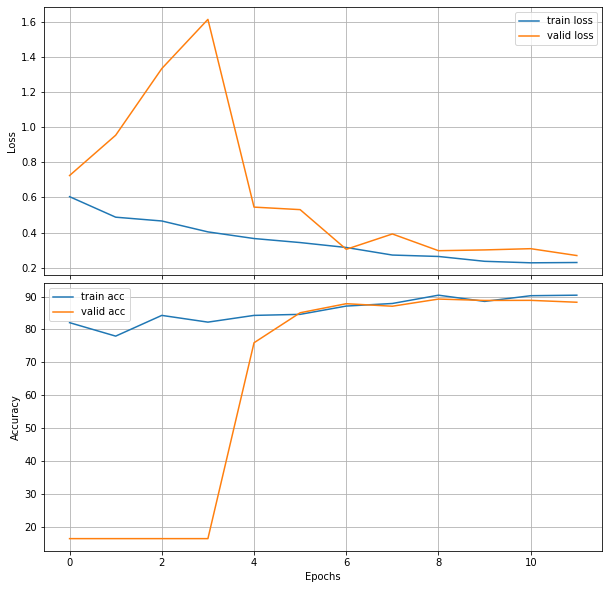

Subject No: 2
g1dual2_epo.fif
g1solo2_epo.fif
Reading ./data/g1dual2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
636 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g1solo2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
252 matching events found
No baseline correction applied
0 projection items activated
CNN(
  (layer1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Sequential(
    (0): Conv2d(1, 128, kernel_size=(32, 1), stride=(1, 1))
    (1): Tanh()
  )
  (layer3_1): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 5), stride=(1, 5))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()

test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 1., 0., 1., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor(

test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[

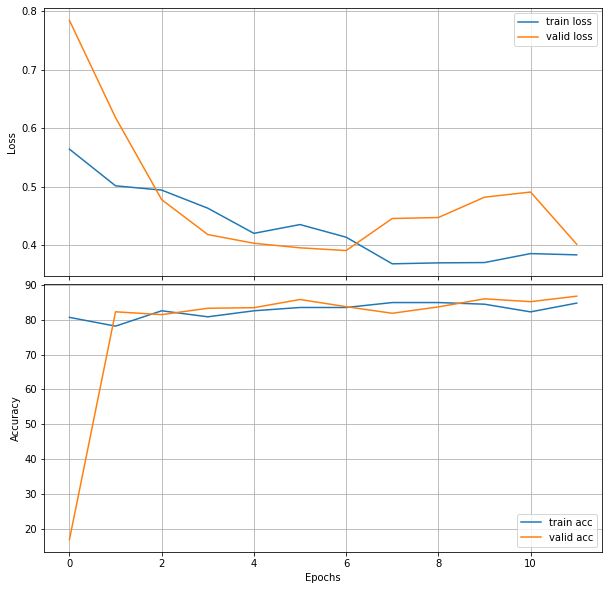

Subject No: 3
g2dual1_epo.fif
g2solo1_epo.fif
Reading ./data/g2dual1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
672 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g2solo1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
276 matching events found
No baseline correction applied
0 projection items activated
CNN(
  (layer1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Sequential(
    (0): Conv2d(1, 128, kernel_size=(32, 1), stride=(1, 1))
    (1): Tanh()
  )
  (layer3_1): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 5), stride=(1, 5))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()

test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[

test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[

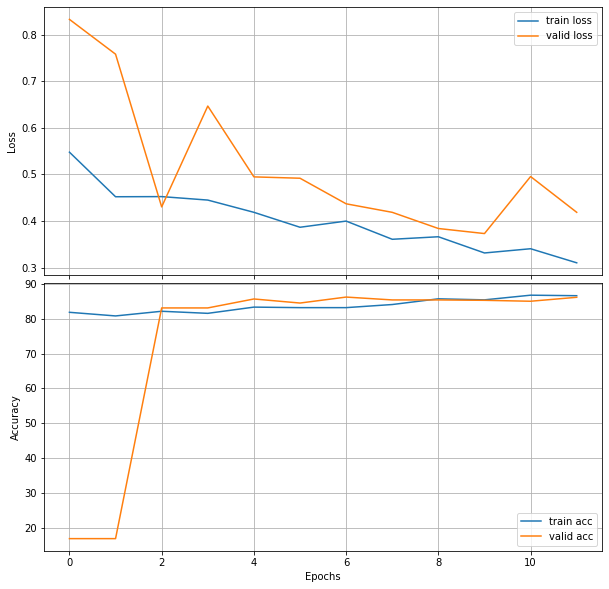

Subject No: 4
g2dual2_epo.fif
g2solo2_epo.fif
Reading ./data/g2dual2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
672 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g2solo2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
444 matching events found
No baseline correction applied
0 projection items activated
CNN(
  (layer1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Sequential(
    (0): Conv2d(1, 128, kernel_size=(32, 1), stride=(1, 1))
    (1): Tanh()
  )
  (layer3_1): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 5), stride=(1, 5))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()

test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 

test predicted tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 1., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor(

test predicted tensor([[0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
         1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 0.,
         1., 1., 0., 0., 1., 1., 0., 1., 1., 0.]], device='cuda:0')
test predicted tensor([[1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1.,
         0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0.,
         1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0.,
         0., 0., 0., 1., 0., 1., 0., 0., 0., 1.]], device='cuda:0')
test predicted tensor([[0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1.,
         0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1.,
         0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0.,
         1., 0., 0., 1., 0., 1., 0., 1., 1., 1.]], device='cuda:0')
test predicted tensor(

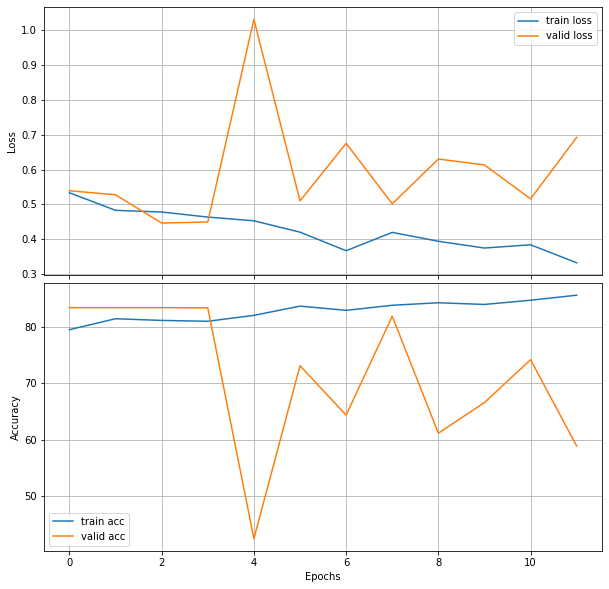

Subject No: 5
g3dual1_epo.fif
g3solo1_epo.fif
Reading ./data/g3dual1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
588 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g3solo1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
336 matching events found
No baseline correction applied
0 projection items activated
CNN(
  (layer1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Sequential(
    (0): Conv2d(1, 128, kernel_size=(32, 1), stride=(1, 1))
    (1): Tanh()
  )
  (layer3_1): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 5), stride=(1, 5))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()

test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 

test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 

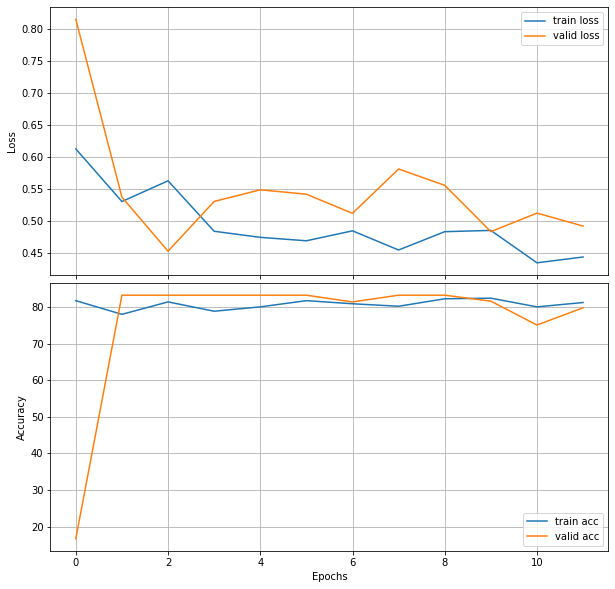

Subject No: 6
g3dual2_epo.fif
g3solo2_epo.fif
Reading ./data/g3dual2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
588 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g3solo2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
216 matching events found
No baseline correction applied
0 projection items activated
CNN(
  (layer1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Sequential(
    (0): Conv2d(1, 128, kernel_size=(32, 1), stride=(1, 1))
    (1): Tanh()
  )
  (layer3_1): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 5), stride=(1, 5))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()

test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 

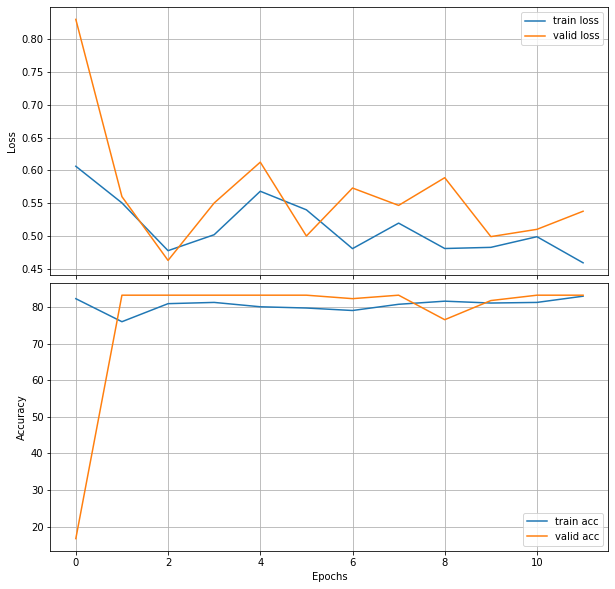

Subject No: 7
g4dual1_epo.fif
g4solo1_epo.fif
Reading ./data/g4dual1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
624 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g4solo1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
192 matching events found
No baseline correction applied
0 projection items activated
CNN(
  (layer1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Sequential(
    (0): Conv2d(1, 128, kernel_size=(32, 1), stride=(1, 1))
    (1): Tanh()
  )
  (layer3_1): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 5), stride=(1, 5))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()

test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
Epoch: 06 | Epoch Time: 0m 0

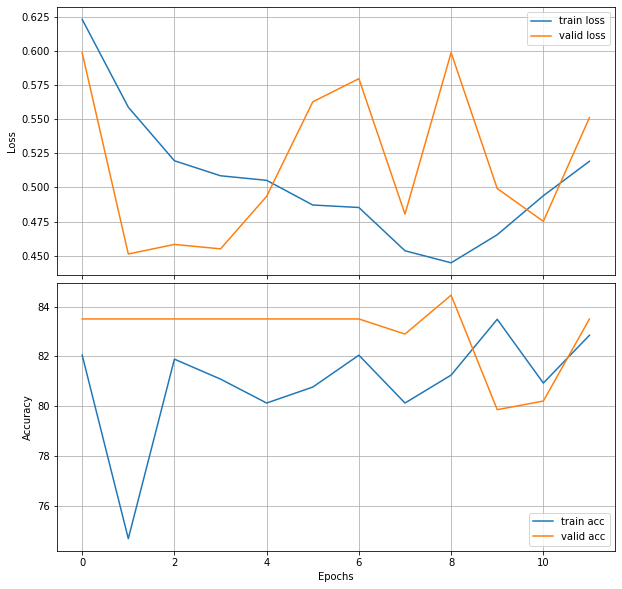

Subject No: 8
g4dual2_epo.fif
g4solo2_epo.fif
Reading ./data/g4dual2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
624 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g4solo2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
168 matching events found
No baseline correction applied
0 projection items activated
CNN(
  (layer1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Sequential(
    (0): Conv2d(1, 128, kernel_size=(32, 1), stride=(1, 1))
    (1): Tanh()
  )
  (layer3_1): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 5), stride=(1, 5))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()

test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.480 | Train Acc: 82.05%
	 Val. Loss: 0.550 |  Val. Acc: 83.77%
test predicted tensor([[0

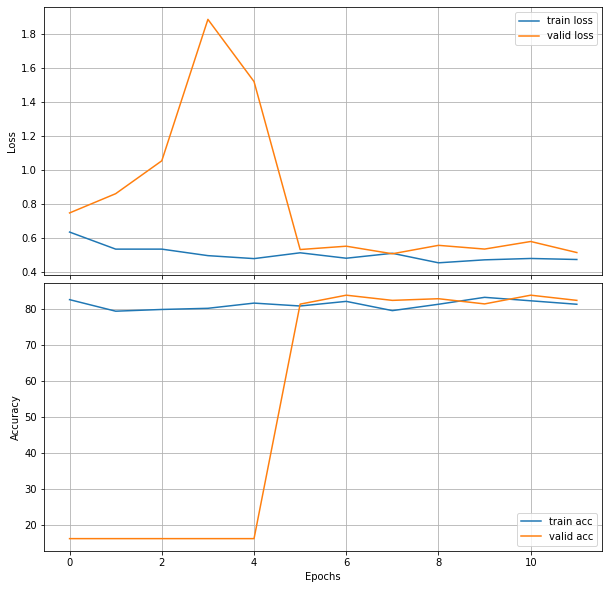

Subject No: 9
g5dual1_epo.fif
g5solo1_epo.fif
Reading ./data/g5dual1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
552 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g5solo1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
CNN(
  (layer1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Sequential(
    (0): Conv2d(1, 128, kernel_size=(32, 1), stride=(1, 1))
    (1): Tanh()
  )
  (layer3_1): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 5), stride=(1, 5))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()

test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 1., 0., 0., 1., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 1., 0.]], device='cuda:0')
test predicted tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.345 | Train Acc: 85.14%
	 Val. Loss: 0.401 |  Val. Acc: 85.79%
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0

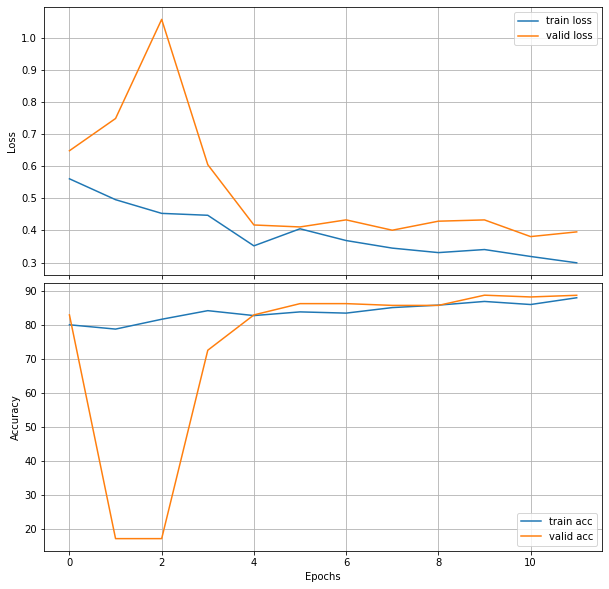

Subject No: 10
g5dual2_epo.fif
g5solo2_epo.fif
Reading ./data/g5dual2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
552 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g5solo2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
CNN(
  (layer1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Sequential(
    (0): Conv2d(1, 128, kernel_size=(32, 1), stride=(1, 1))
    (1): Tanh()
  )
  (layer3_1): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 5), stride=(1, 5))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh(

test predicted tensor([[1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
         1., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1.,
         0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 1., 0., 0., 0., 0., 0., 1., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
         0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], device='cuda:0')
test predicted tensor(

test predicted tensor([[1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], device='cuda:0')
test predicted tensor(

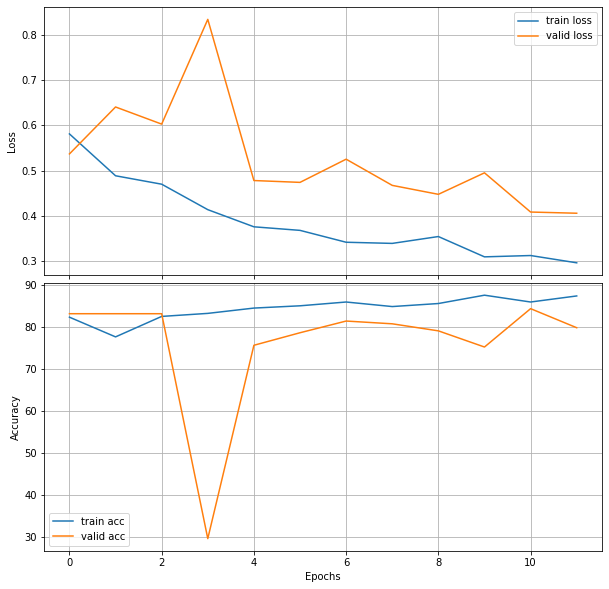

Subject No: 11
g6dual1_epo.fif
g6solo1_epo.fif
Reading ./data/g6dual1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
744 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g6solo1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
216 matching events found
No baseline correction applied
0 projection items activated
CNN(
  (layer1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Sequential(
    (0): Conv2d(1, 128, kernel_size=(32, 1), stride=(1, 1))
    (1): Tanh()
  )
  (layer3_1): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 5), stride=(1, 5))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh(

test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor(

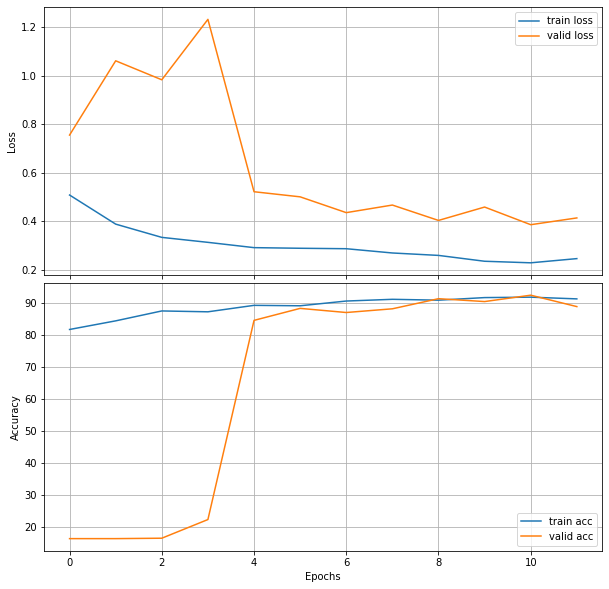

Subject No: 12
g6dual2_epo.fif
g6solo2_epo.fif
Reading ./data/g6dual2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
744 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g6solo2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
192 matching events found
No baseline correction applied
0 projection items activated
CNN(
  (layer1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Sequential(
    (0): Conv2d(1, 128, kernel_size=(32, 1), stride=(1, 1))
    (1): Tanh()
  )
  (layer3_1): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 5), stride=(1, 5))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh(

test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], device='cuda:0')
Epoch: 06 | Epoch Time

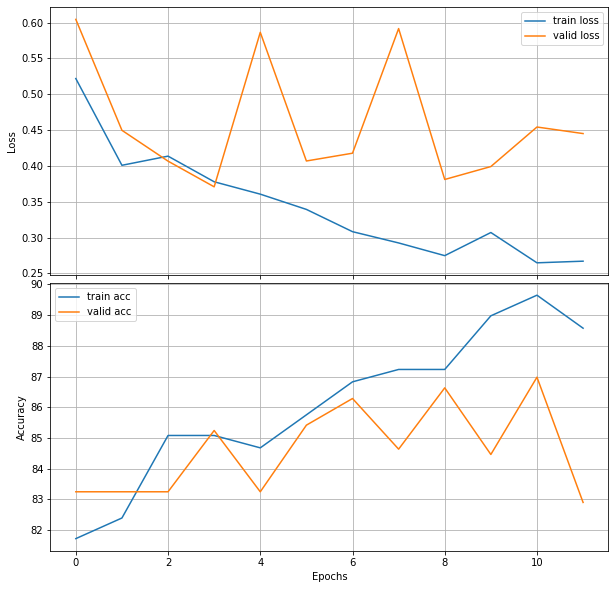

Subject No: 13
g7dual1_epo.fif
g7solo1_epo.fif
Reading ./data/g7dual1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
708 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g7solo1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
240 matching events found
No baseline correction applied
0 projection items activated
CNN(
  (layer1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Sequential(
    (0): Conv2d(1, 128, kernel_size=(32, 1), stride=(1, 1))
    (1): Tanh()
  )
  (layer3_1): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 5), stride=(1, 5))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh(

test predicted tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor(

test predicted tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor(

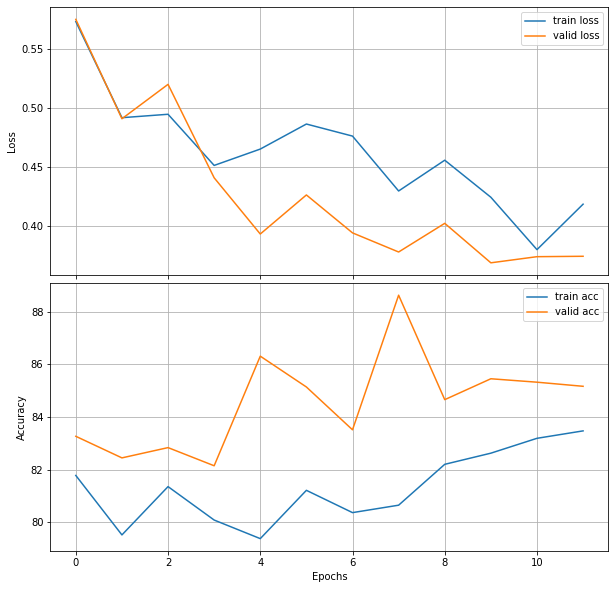

Subject No: 14
g7dual2_epo.fif
g7solo2_epo.fif
Reading ./data/g7dual2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
708 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g7solo2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
336 matching events found
No baseline correction applied
0 projection items activated
CNN(
  (layer1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Sequential(
    (0): Conv2d(1, 128, kernel_size=(32, 1), stride=(1, 1))
    (1): Tanh()
  )
  (layer3_1): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 5), stride=(1, 5))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh(

test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor(

test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 1., 1., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor(

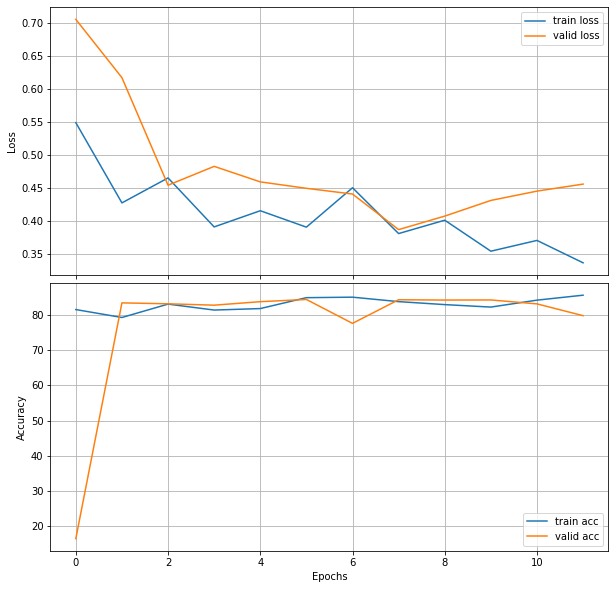

Subject No: 15
g8dual1_epo.fif
g8solo1_epo.fif
Reading ./data/g8dual1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
624 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g8solo1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
192 matching events found
No baseline correction applied
0 projection items activated
CNN(
  (layer1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Sequential(
    (0): Conv2d(1, 128, kernel_size=(32, 1), stride=(1, 1))
    (1): Tanh()
  )
  (layer3_1): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 5), stride=(1, 5))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh(

test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 1., 0., 0.]], device='cuda:0')
Epoch: 06 | Epoch Time

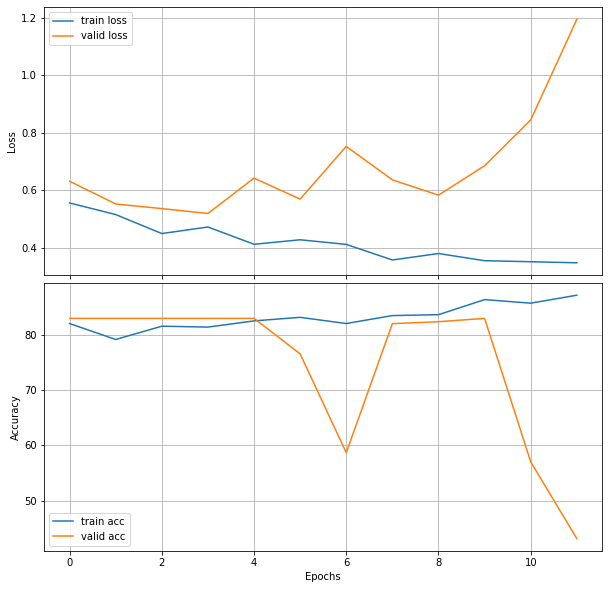

Subject No: 16
g8dual2_epo.fif
g8solo2_epo.fif
Reading ./data/g8dual2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
624 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g8solo2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated
CNN(
  (layer1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Sequential(
    (0): Conv2d(1, 128, kernel_size=(32, 1), stride=(1, 1))
    (1): Tanh()
  )
  (layer3_1): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 5), stride=(1, 5))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh(

test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 

test predicted tensor([[0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[

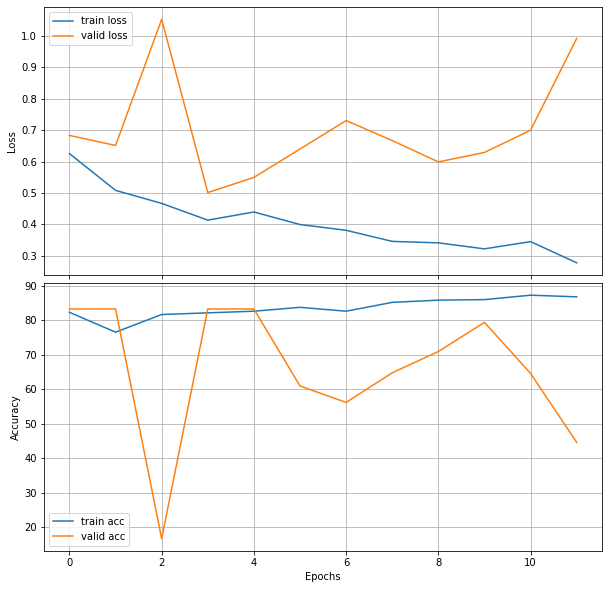

Subject No: 17
g9dual1_epo.fif
g9solo1_epo.fif
Reading ./data/g9dual1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
588 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g9solo1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
252 matching events found
No baseline correction applied
0 projection items activated
CNN(
  (layer1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Sequential(
    (0): Conv2d(1, 128, kernel_size=(32, 1), stride=(1, 1))
    (1): Tanh()
  )
  (layer3_1): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 5), stride=(1, 5))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh(

test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 

test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 

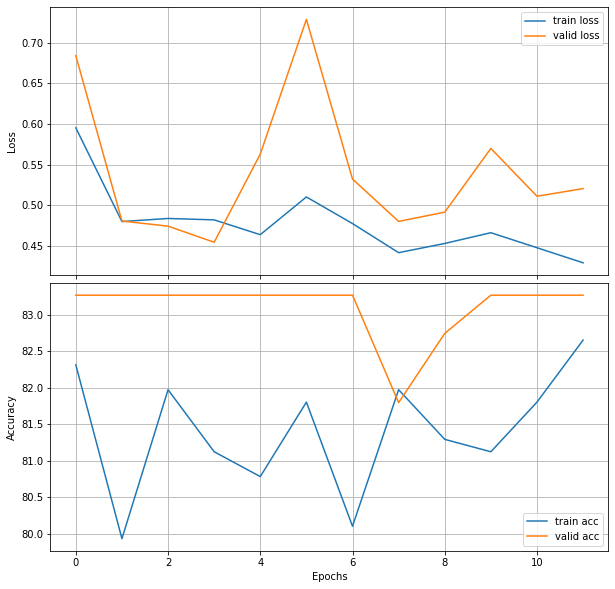

Subject No: 18
g9dual2_epo.fif
g9solo2_epo.fif
Reading ./data/g9dual2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
588 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g9solo2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
252 matching events found
No baseline correction applied
0 projection items activated
CNN(
  (layer1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Sequential(
    (0): Conv2d(1, 128, kernel_size=(32, 1), stride=(1, 1))
    (1): Tanh()
  )
  (layer3_1): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 5), stride=(1, 5))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh(

test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 

test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 

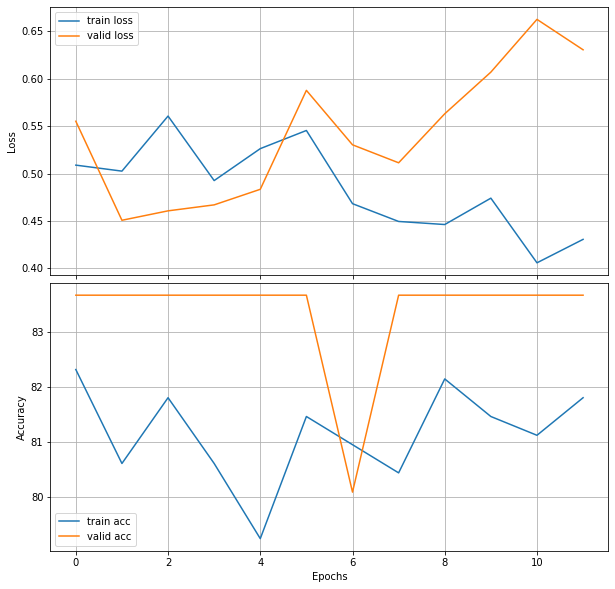

Subject No: 19
g10dual1_epo.fif
g10solo1_epo.fif
Reading ./data/g10dual1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
684 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g10solo1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
276 matching events found
No baseline correction applied
0 projection items activated
CNN(
  (layer1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Sequential(
    (0): Conv2d(1, 128, kernel_size=(32, 1), stride=(1, 1))
    (1): Tanh()
  )
  (layer3_1): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 5), stride=(1, 5))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): T

test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0.

test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 

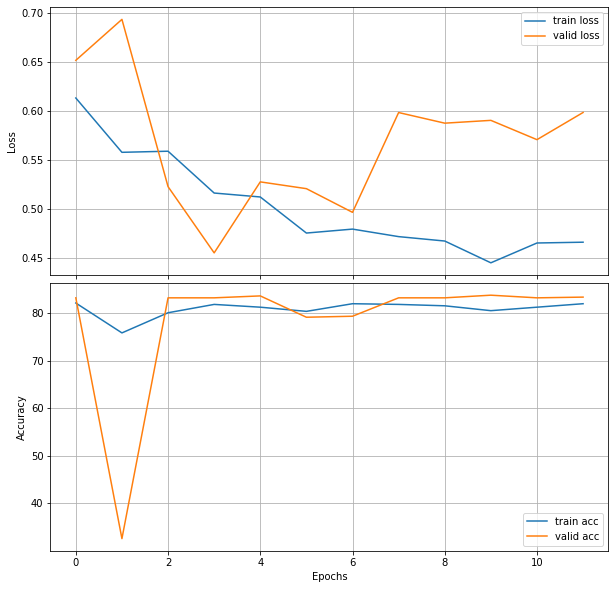

Subject No: 20
g10dual2_epo.fif
g10solo2_epo.fif
Reading ./data/g10dual2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
684 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g10solo2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
228 matching events found
No baseline correction applied
0 projection items activated
CNN(
  (layer1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Sequential(
    (0): Conv2d(1, 128, kernel_size=(32, 1), stride=(1, 1))
    (1): Tanh()
  )
  (layer3_1): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 5), stride=(1, 5))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): T

test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], device='cuda:0')
test predicted tensor([[0.

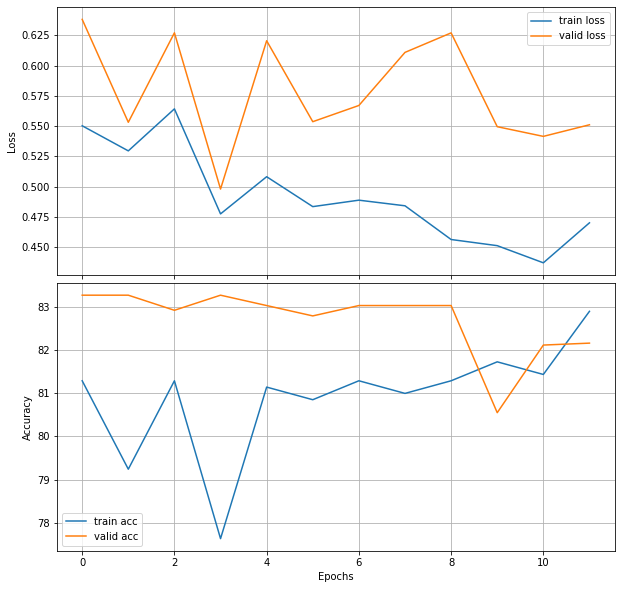

Subject No: 21
g11dual1_epo.fif
g11solo1_epo.fif
Reading ./data/g11dual1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
516 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g11solo1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
192 matching events found
No baseline correction applied
0 projection items activated
CNN(
  (layer1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Sequential(
    (0): Conv2d(1, 128, kernel_size=(32, 1), stride=(1, 1))
    (1): Tanh()
  )
  (layer3_1): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 5), stride=(1, 5))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): T

test predicted tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
         0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
         0., 0., 1., 0., 1., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], device='cuda:0')
Epoch: 06 | Epoch Time

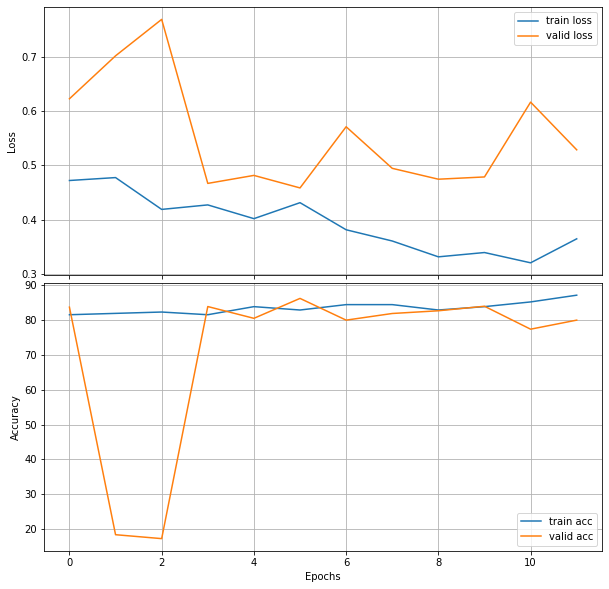

Subject No: 22
g11dual2_epo.fif
g11solo2_epo.fif
Reading ./data/g11dual2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
516 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g11solo2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
156 matching events found
No baseline correction applied
0 projection items activated
CNN(
  (layer1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Sequential(
    (0): Conv2d(1, 128, kernel_size=(32, 1), stride=(1, 1))
    (1): Tanh()
  )
  (layer3_1): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 5), stride=(1, 5))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): T

test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]], device='cuda:0')
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.450 | Train Acc: 84.69%
	 Val. Loss: 0.442 |  Val. Acc: 87.23%
test predicted tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 

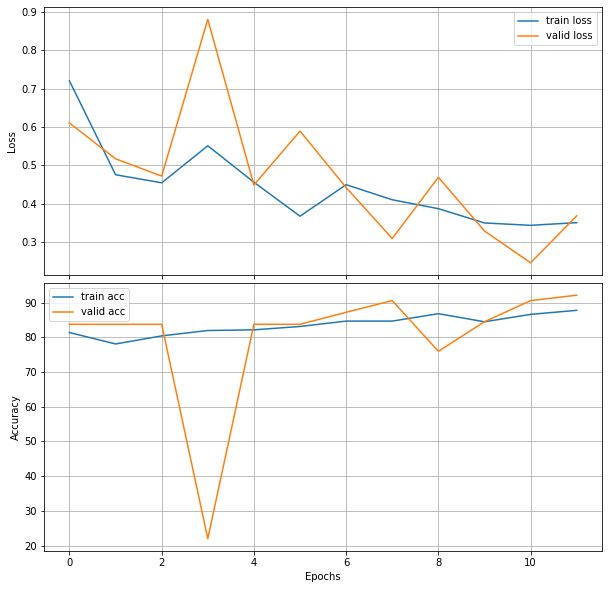

Subject No: 23
g12dual1_epo.fif
g12solo1_epo.fif
Reading ./data/g12dual1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
456 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g12solo1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
192 matching events found
No baseline correction applied
0 projection items activated
CNN(
  (layer1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Sequential(
    (0): Conv2d(1, 128, kernel_size=(32, 1), stride=(1, 1))
    (1): Tanh()
  )
  (layer3_1): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 5), stride=(1, 5))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): T

test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0., 0., 1.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 1., 0., 0., 0., 0.]], device='cuda:0')
Epoch: 06 | Epoch Time

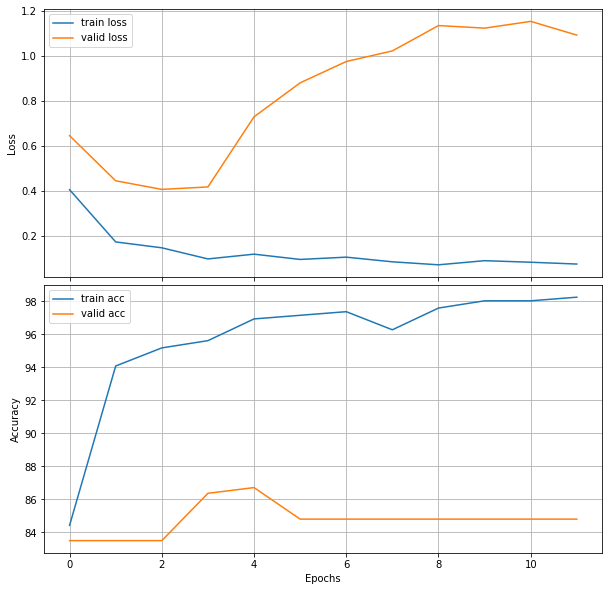

Subject No: 24
g12dual2_epo.fif
g12solo2_epo.fif
Reading ./data/g12dual2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
456 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g12solo2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
204 matching events found
No baseline correction applied
0 projection items activated
CNN(
  (layer1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Sequential(
    (0): Conv2d(1, 128, kernel_size=(32, 1), stride=(1, 1))
    (1): Tanh()
  )
  (layer3_1): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 5), stride=(1, 5))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): T

test predicted tensor([[1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0.,
         1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0.,
         1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], device='cuda:0')
test predicted tensor([[0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 0., 1., 1.]], device='cuda:0')
test predicted tensor([[1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1.,
         1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 0., 1., 0., 1., 0., 1., 1., 1.]], device='cuda:0')
test predicted tensor(

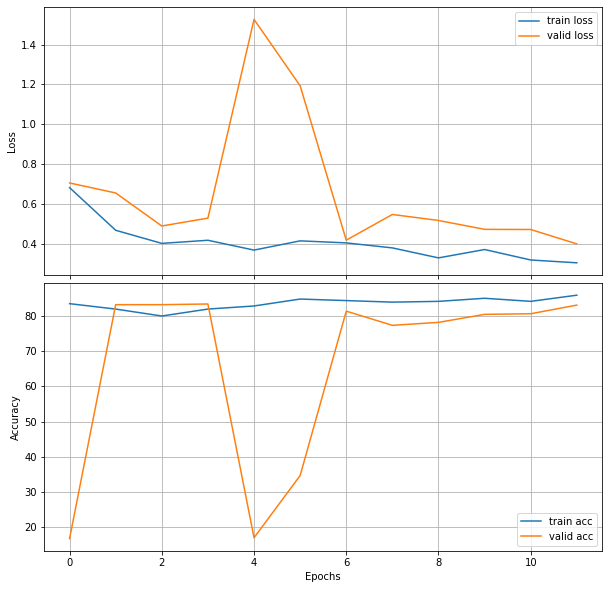

Subject No: 25
g13dual1_epo.fif
g13solo1_epo.fif
Reading ./data/g13dual1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
1176 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g13solo1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
516 matching events found
No baseline correction applied
0 projection items activated
CNN(
  (layer1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Sequential(
    (0): Conv2d(1, 128, kernel_size=(32, 1), stride=(1, 1))
    (1): Tanh()
  )
  (layer3_1): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 5), stride=(1, 5))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): 

test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor(

test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[

test predicted tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor(

test predicted tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor(

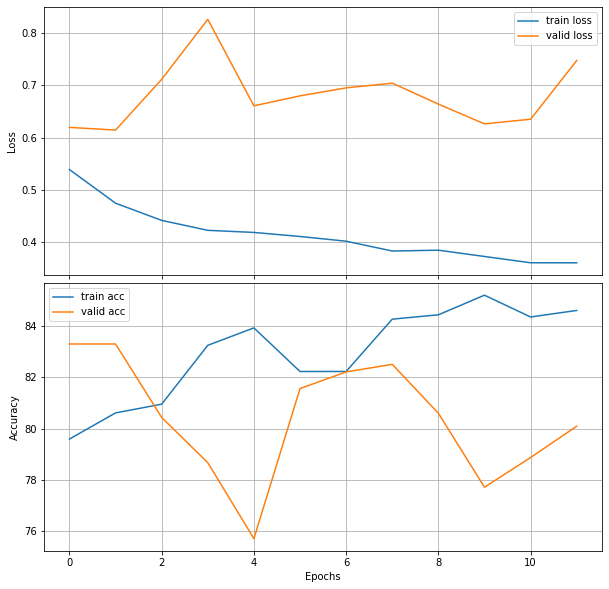

Subject No: 26
g13dual2_epo.fif
g13solo2_epo.fif
Reading ./data/g13dual2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
1176 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g13solo2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
204 matching events found
No baseline correction applied
0 projection items activated
CNN(
  (layer1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Sequential(
    (0): Conv2d(1, 128, kernel_size=(32, 1), stride=(1, 1))
    (1): Tanh()
  )
  (layer3_1): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 5), stride=(1, 5))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): 

test predicted tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 1., 0., 0.]], device='cuda:0')
test predicted tensor(

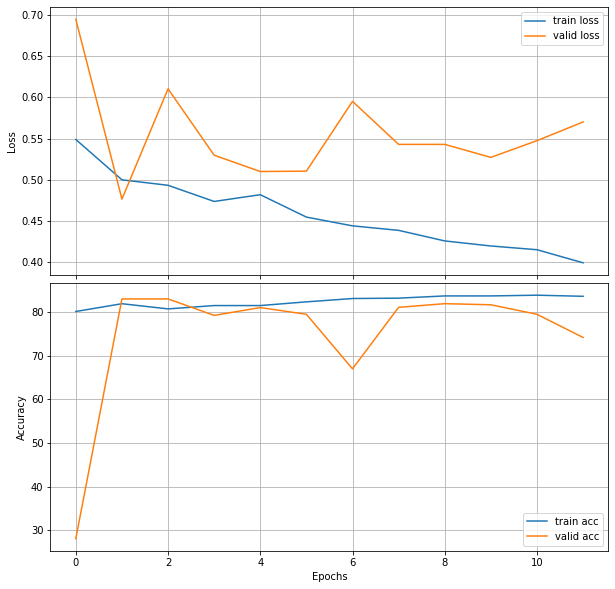

Subject No: 27
g14dual1_epo.fif
g14solo1_epo.fif
Reading ./data/g14dual1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
540 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g14solo1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
204 matching events found
No baseline correction applied
0 projection items activated
CNN(
  (layer1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Sequential(
    (0): Conv2d(1, 128, kernel_size=(32, 1), stride=(1, 1))
    (1): Tanh()
  )
  (layer3_1): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 5), stride=(1, 5))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): T

test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 

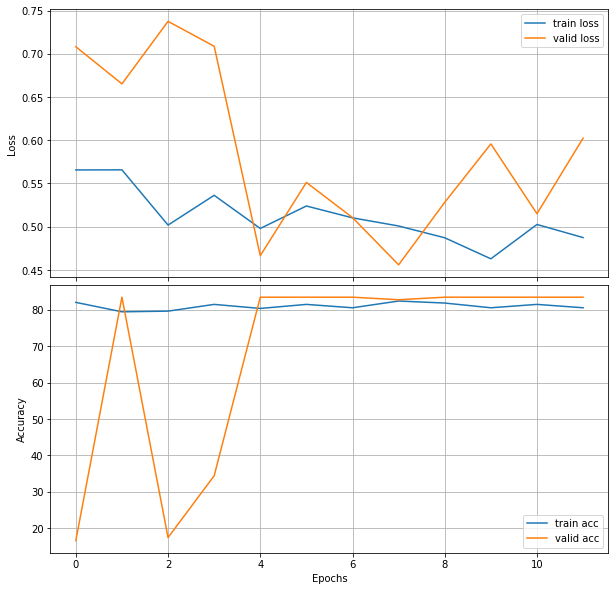

Subject No: 28
g14dual2_epo.fif
g14solo2_epo.fif
Reading ./data/g14dual2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
540 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g14solo2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
156 matching events found
No baseline correction applied
0 projection items activated
CNN(
  (layer1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Sequential(
    (0): Conv2d(1, 128, kernel_size=(32, 1), stride=(1, 1))
    (1): Tanh()
  )
  (layer3_1): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 5), stride=(1, 5))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): T

test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]], device='cuda:0')
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.510 | Train Acc: 81.67%
	 Val. Loss: 0.797 |  Val. Acc: 83.25%
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 

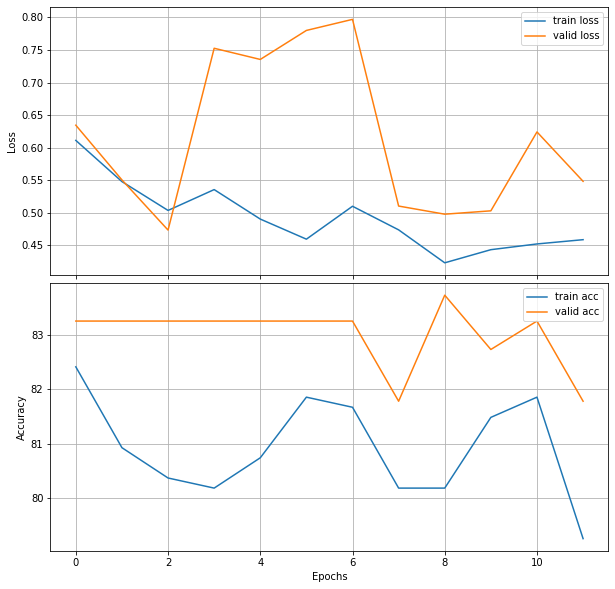

Subject No: 29
g15dual1_epo.fif
g15solo1_epo.fif
Reading ./data/g15dual1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
684 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g15solo1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
180 matching events found
No baseline correction applied
0 projection items activated
CNN(
  (layer1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Sequential(
    (0): Conv2d(1, 128, kernel_size=(32, 1), stride=(1, 1))
    (1): Tanh()
  )
  (layer3_1): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 5), stride=(1, 5))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): T

test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]], device='cuda:0')
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.362 | Train Acc: 85.67%
	 Val. Loss: 0

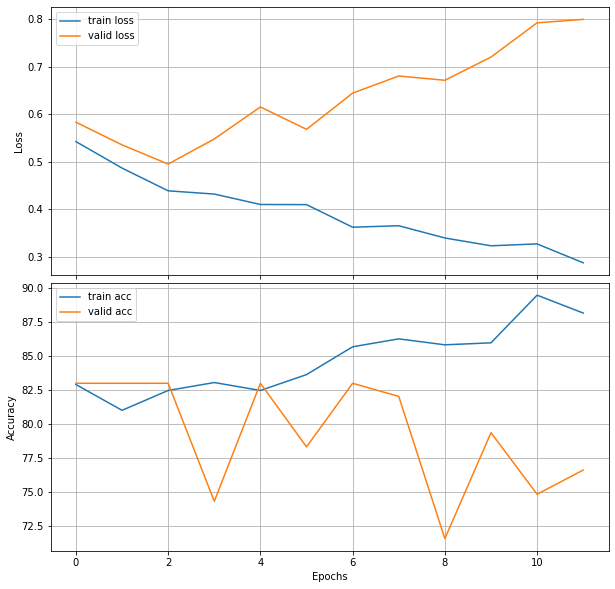

Subject No: 30
g15dual2_epo.fif
g15solo2_epo.fif
Reading ./data/g15dual2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
684 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g15solo2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
216 matching events found
No baseline correction applied
0 projection items activated
CNN(
  (layer1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Sequential(
    (0): Conv2d(1, 128, kernel_size=(32, 1), stride=(1, 1))
    (1): Tanh()
  )
  (layer3_1): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 5), stride=(1, 5))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): T

test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 1., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 1., 0., 1.]], device='cuda:0')
test predicted tensor(

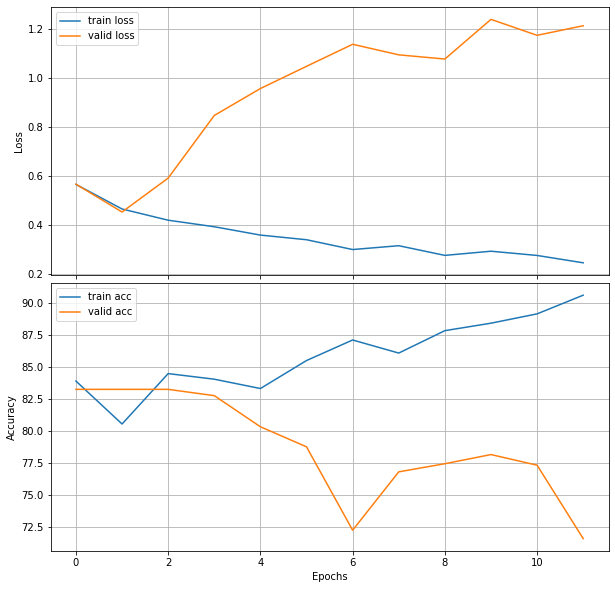

Subject No: 31
g16dual1_epo.fif
g16solo1_epo.fif
Reading ./data/g16dual1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
540 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g16solo1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
228 matching events found
No baseline correction applied
0 projection items activated
CNN(
  (layer1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Sequential(
    (0): Conv2d(1, 128, kernel_size=(32, 1), stride=(1, 1))
    (1): Tanh()
  )
  (layer3_1): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 5), stride=(1, 5))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): T

test predicted tensor([[0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1.,
         1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 0., 1., 1., 1., 1.]], device='cuda:0')
test predicted tensor([[1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1.,
         0., 1., 0., 1., 1., 1., 1., 1., 1., 0.]], device='cuda:0')
test predicted tensor([[0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 0., 1., 1., 0., 1., 1., 1., 1., 1.]], device='cuda:0')
test predicted tensor(

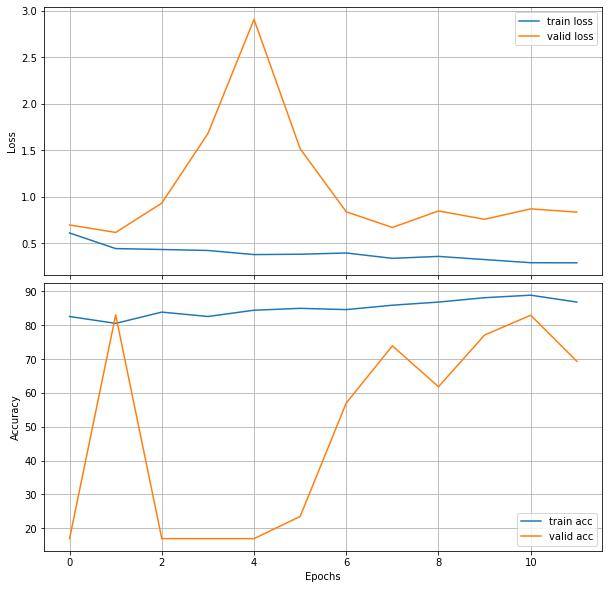

Subject No: 32
g16dual2_epo.fif
g16solo2_epo.fif
Reading ./data/g16dual2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
540 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g16solo2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
252 matching events found
No baseline correction applied
0 projection items activated
CNN(
  (layer1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Sequential(
    (0): Conv2d(1, 128, kernel_size=(32, 1), stride=(1, 1))
    (1): Tanh()
  )
  (layer3_1): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 5), stride=(1, 5))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): T

test predicted tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor(

test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[

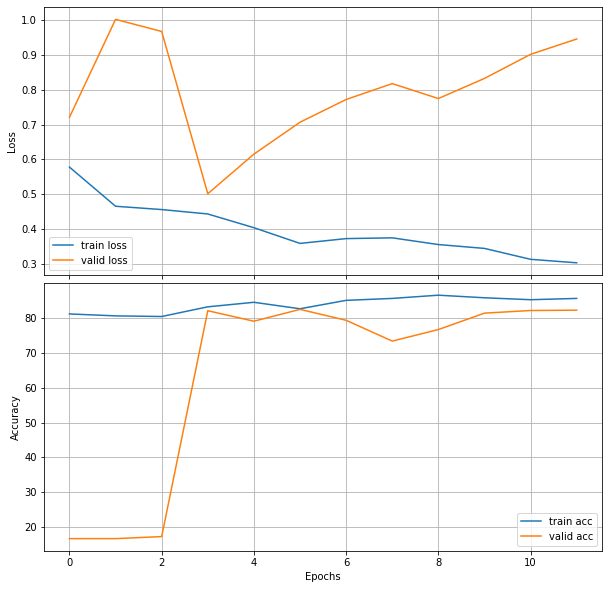

Subject No: 33
g17dual1_epo.fif
g17solo1_epo.fif
Reading ./data/g17dual1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
588 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g17solo1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
216 matching events found
No baseline correction applied
0 projection items activated
CNN(
  (layer1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Sequential(
    (0): Conv2d(1, 128, kernel_size=(32, 1), stride=(1, 1))
    (1): Tanh()
  )
  (layer3_1): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 5), stride=(1, 5))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): T

test predicted tensor([[0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 1., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0.,
         0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
         1., 1., 0., 0., 0., 1., 0., 1., 0., 1.]], device='cuda:0')
test predicted tensor(

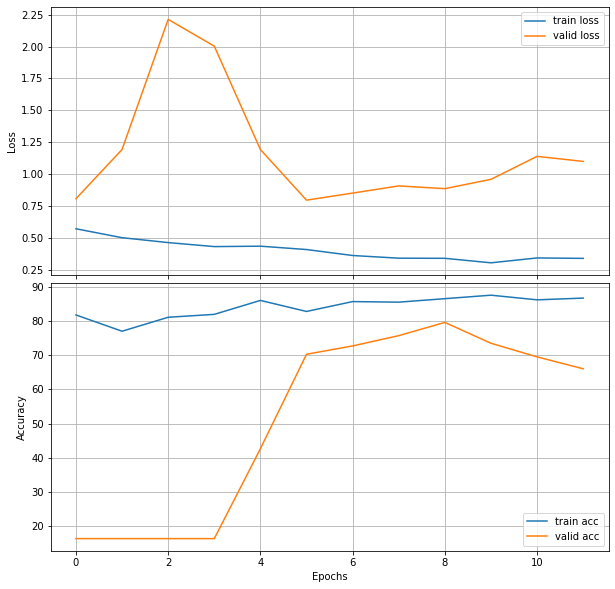

Subject No: 34
g17dual2_epo.fif
g17solo2_epo.fif
Reading ./data/g17dual2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
588 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g17solo2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
264 matching events found
No baseline correction applied
0 projection items activated
CNN(
  (layer1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Sequential(
    (0): Conv2d(1, 128, kernel_size=(32, 1), stride=(1, 1))
    (1): Tanh()
  )
  (layer3_1): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 5), stride=(1, 5))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): T

test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0.

test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0.

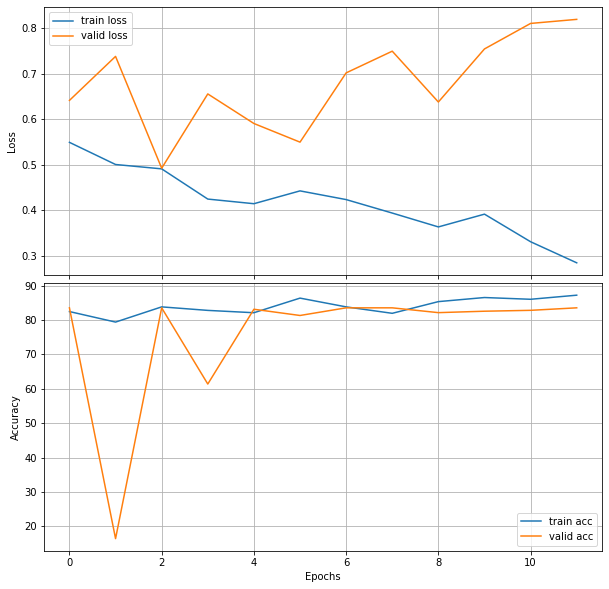

Subject No: 35
g18dual1_epo.fif
g18solo1_epo.fif
Reading ./data/g18dual1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
852 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g18solo1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
252 matching events found
No baseline correction applied
0 projection items activated
CNN(
  (layer1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Sequential(
    (0): Conv2d(1, 128, kernel_size=(32, 1), stride=(1, 1))
    (1): Tanh()
  )
  (layer3_1): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 5), stride=(1, 5))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): T

test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], device='cuda:0')
test predicted tensor(

test predicted tensor([[0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
         1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 1., 0., 0., 0., 1., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.]], device='cuda:0')
Epoch: 11 | Epoch Time: 0m 0s
	Train L

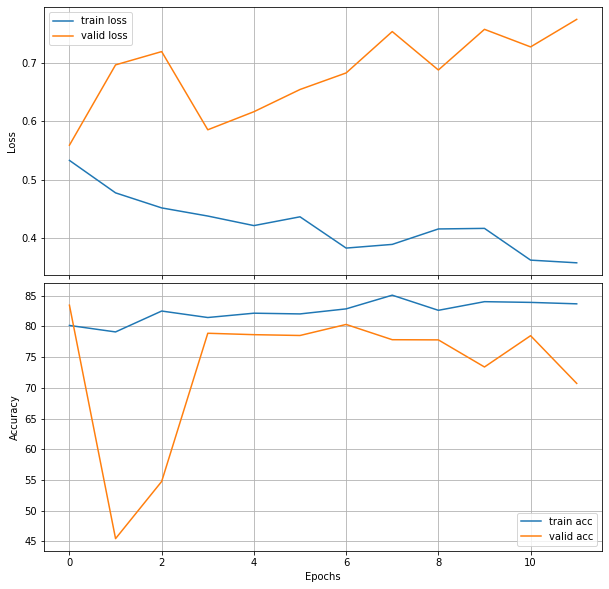

Subject No: 36
g18dual2_epo.fif
g18solo2_epo.fif
Reading ./data/g18dual2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
852 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g18solo2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated
CNN(
  (layer1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Sequential(
    (0): Conv2d(1, 128, kernel_size=(32, 1), stride=(1, 1))
    (1): Tanh()
  )
  (layer3_1): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 5), stride=(1, 5))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): T

test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[

test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor(

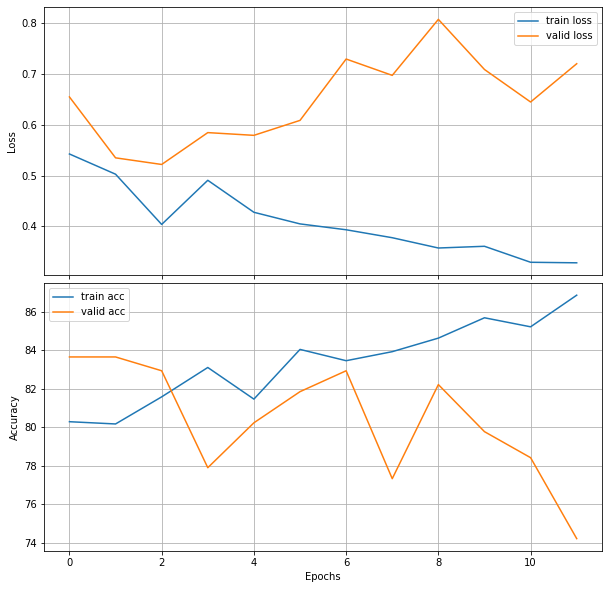

Subject No: 37
g19dual1_epo.fif
g19solo1_epo.fif
Reading ./data/g19dual1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
756 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g19solo1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
252 matching events found
No baseline correction applied
0 projection items activated
CNN(
  (layer1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Sequential(
    (0): Conv2d(1, 128, kernel_size=(32, 1), stride=(1, 1))
    (1): Tanh()
  )
  (layer3_1): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 5), stride=(1, 5))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): T

test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], device='cuda:0')
test predicted tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor(

test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
         1., 0., 0., 0., 1., 0., 0., 0., 0., 1.]], device='cuda:0')
test predicted tensor([[0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 1., 1., 0., 0., 1., 0., 0., 0., 1.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], device='cuda:0')
test predicted tensor(

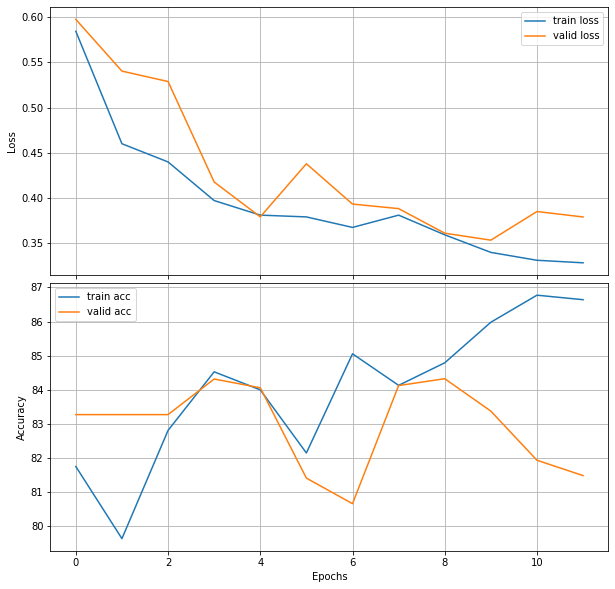

Subject No: 38
g19dual2_epo.fif
g19solo2_epo.fif
Reading ./data/g19dual2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
756 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g19solo2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
156 matching events found
No baseline correction applied
0 projection items activated
CNN(
  (layer1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Sequential(
    (0): Conv2d(1, 128, kernel_size=(32, 1), stride=(1, 1))
    (1): Tanh()
  )
  (layer3_1): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 5), stride=(1, 5))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): T

test predicted tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]], device='cuda:0')
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.409 | Train Acc: 84.39%
	 Val. Loss: 0.362 |  Val. Acc: 85.92%
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

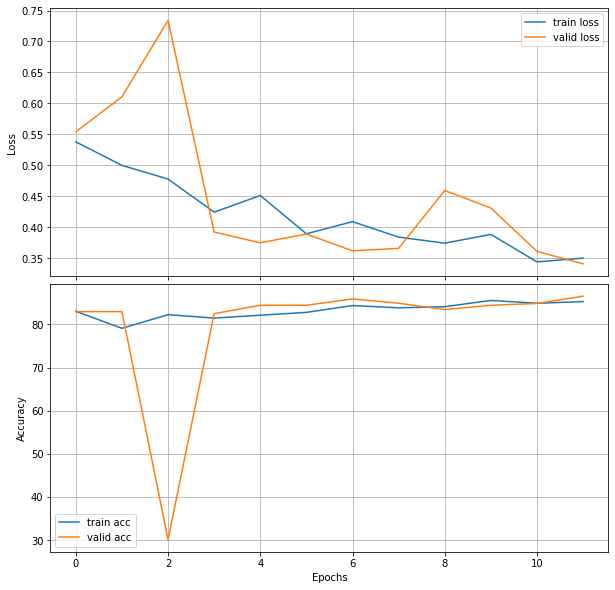

In [8]:
url = './data/'
subject_no = 1
train_acc_list = []
val_acc_list = []
subject_no_list = []

for i in range(1, 20):
    for j in range(1,3):
        
        print("================================================")
        print("================================================")
        print("================================================")
        
        print("Subject No:", subject_no)
        subject_no_list.append(subject_no) # to save in excel
        subject_no += 1
        print(f"g{i}dual{j}_epo.fif")
        print(f"g{i}solo{j}_epo.fif")
        test_file_1 = 'g'+str(i)+'dual'+str(j)+'_epo.fif' # eg. 'g1dual1_epo.fif'
        epoch_1 = read_epochs(url + test_file_1)
        test_file_2 = 'g'+str(i)+'solo'+str(j)+'_epo.fif' # eg. 'g1dual1_epo.fif'
        epoch_2 = read_epochs(url + test_file_2)

        X_1 = epoch_1.get_data()
        y_1 = np.array(epoch_1.events[:, -1], dtype = 'float32')

        X_2 = epoch_2.get_data()
        y_2 = np.array(epoch_2.events[:, -1], dtype = 'float32')


        X_1 = X_1.reshape(X_1.shape[0], 1, X_1.shape[1], X_1.shape[2])
        X_2 = X_2.reshape(X_2.shape[0], 1, X_2.shape[1], X_2.shape[2])


        X_train = torch.Tensor(X_1)
        y_train = torch.Tensor(y_1)
        y_train = y_train-1
        y_train = y_train.unsqueeze(1)

        X_test = torch.Tensor(X_2)
        y_test = torch.Tensor(y_2)
        y_test = y_test-1
        y_test = y_test.unsqueeze(1)

        train_ds = TensorDataset(X_train, y_train)
        valid_ds = TensorDataset(X_test, y_test)

        
        BATCH_SIZE= 64

        train_iterator = torch.utils.data.DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True)
        valid_iterator = torch.utils.data.DataLoader(dataset=valid_ds, batch_size=BATCH_SIZE, shuffle=False)
        
        learning_rate=0.001
        epoches = 50
        input_x = X_train.size()
        
        model = CNN(input_x, input_dim, hidden_dims, output_dim, dropout).to(device)
        model.apply(initialize_weights)
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        print(model)
        
        N_EPOCHS = 12

        best_valid_loss = float('inf')

        train_losses = []
        valid_losses = []

        train_accs = []
        valid_accs = []

        train_predicted_labels = []
        valid_predicted_labels = []

        train_true_labels = []
        valid_true_labels = []

        # for i, model in enumerate(models):
        #     print(f"Training {type(model).__name__}")

        #     start_time = time.time()

        for epoch in range(N_EPOCHS):
            start_time = time.time()

            train_loss, train_acc, predicted_train = train(model, train_iterator, optimizer, criterion)
            valid_loss, valid_acc, predicted_eval = evaluate(model, valid_iterator, criterion)

            train_losses.append(train_loss); train_accs.append(train_acc); train_predicted_labels.append(predicted_train)
            valid_losses.append(valid_loss); valid_accs.append(valid_acc); valid_predicted_labels.append(predicted_eval)
            
            end_time = time.time()

            epoch_mins, epoch_secs = epoch_time(start_time, end_time)

            if (epoch+1) % 1 == 0:
                print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
                print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}%')
                print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc:.2f}%')

        #         print(predicted_train)
        #         print(predicted_eval)

            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
        
        # to save in excel
        train_acc_list.append(train_acc)
        val_acc_list.append(valid_acc)
        
        #to plot
        fig,ax = plt.subplots(2,1,sharex=True,figsize=(10,10))
        ax[0].plot(np.arange(N_EPOCHS),train_losses,label = "train loss")
        ax[0].plot(np.arange(N_EPOCHS),valid_losses, label = "valid loss")
        ax[1].plot(np.arange(N_EPOCHS),train_accs,label = "train acc")
        ax[1].plot(np.arange(N_EPOCHS),valid_accs,label = "valid acc")

        plt.subplots_adjust(hspace=0.03)
        ax[1].set_xlabel("Epochs")
        ax[0].set_ylabel("Loss")
        ax[1].set_ylabel("Accuracy")
        ax[0].legend()
        ax[1].legend()
        ax[0].grid(True)
        ax[1].grid(True)
        plt.show()

## Save accuracy for both train and val in excel

In [9]:
import xlsxwriter

workbook = xlsxwriter.Workbook('Conv2D ACC.xlsx')
worksheet = workbook.add_worksheet()

worksheet.write(0, 0, 'Subject No')
worksheet.write(0, 1, 'Train Accuracy')
worksheet.write(0, 2, 'Val Accuracy')

for i in range(len(train_acc_list)):
    worksheet.write(i+1, 0, subject_no_list[i])
    worksheet.write(i+1, 1, train_acc_list[i]) 
    worksheet.write(i+1, 2, val_acc_list[i])
    
workbook.close()